# Logits Visualisierung - Sprachmodell

Dieses Notebook zeigt die Logits und Wahrscheinlichkeiten des trainierten Sprachmodells als Heatmaps und Diagramme.

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Importiere Modell-Klassen
from simple_language_model import load_model, Tokenizer, SimpleLanguageModel

# Stil setzen
plt.style.use('dark_background')
sns.set_theme(style='darkgrid')

print("Bibliotheken geladen!")

Bibliotheken geladen!


## 1. Modell laden

In [3]:
# Modell laden
model_dir = Path("models/lstm_model")

if not model_dir.exists():
    print("Modell nicht gefunden! Bitte zuerst trainieren:")
    print("  python simple_language_model.py")
else:
    model, tokenizer = load_model(str(model_dir))
    print(f"\nVokabular: {tokenizer.vocab_size} Wörter")

📂 Config geladen: models\lstm_model\config.json
🧠 Modell erstellt:
   - Embedding: 69 Wörter -> 32D Vektoren
   - LSTM: 32D -> 64D hidden
   - Output: 64D -> 69 Logits
📂 Modell geladen: models\lstm_model\model.pt
📂 Tokenizer geladen: models\lstm_model\tokenizer.json (69 Wörter)

✅ Modell bereit für Inferenz!

Vokabular: 69 Wörter


## 2. Logits für einen Text berechnen

In [4]:
def get_logits_and_probs(model, tokenizer, text):
    """Berechnet Logits und Wahrscheinlichkeiten für den nächsten Token."""
    model.eval()
    tokens = tokenizer.encode(text)
    
    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        logits = model(input_tensor)
        last_logits = logits[0, -1, :]  # Nur letzter Token
        probs = F.softmax(last_logits, dim=-1)
    
    return last_logits.numpy(), probs.numpy(), tokens

# Test
test_text = "die katze"
logits, probs, tokens = get_logits_and_probs(model, tokenizer, test_text)
print(f"Text: '{test_text}'")
print(f"Tokens: {tokens}")
print(f"Logits Shape: {logits.shape}")
print(f"Probs Shape: {probs.shape}")

Text: 'die katze'
Tokens: [4, 5]
Logits Shape: (69,)
Probs Shape: (69,)


## 3. Top-K Balkendiagramm

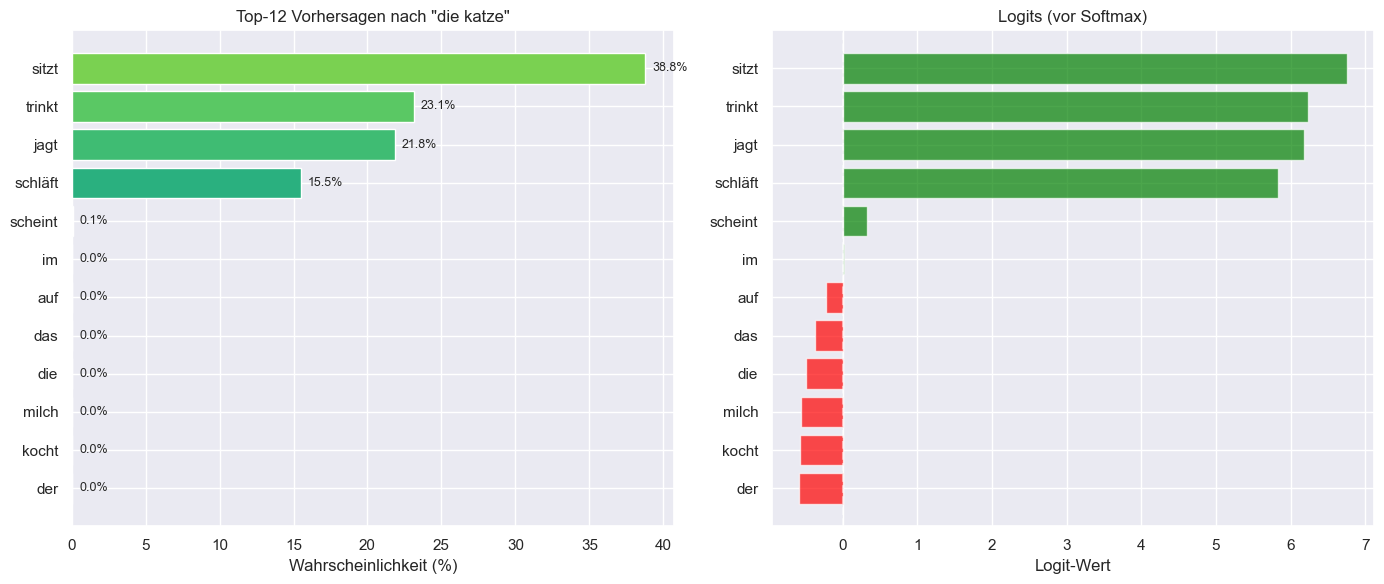

In [5]:
def plot_top_k_bar(model, tokenizer, text, top_k=15):
    """Zeigt die Top-K wahrscheinlichsten Wörter als Balkendiagramm."""
    logits, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K finden
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_words = [tokenizer.idx_to_word.get(i, "<UNK>") for i in top_indices]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Wahrscheinlichkeiten
    colors = plt.cm.viridis(np.linspace(0.8, 0.2, top_k))
    bars1 = ax1.barh(range(top_k), top_probs * 100, color=colors)
    ax1.set_yticks(range(top_k))
    ax1.set_yticklabels(top_words)
    ax1.set_xlabel('Wahrscheinlichkeit (%)')
    ax1.set_title(f'Top-{top_k} Vorhersagen nach "{text}"')
    ax1.invert_yaxis()
    
    # Werte anzeigen
    for bar, prob in zip(bars1, top_probs):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{prob*100:.1f}%', va='center', fontsize=9)
    
    # Logits
    top_logits = logits[top_indices]
    colors2 = ['green' if l > 0 else 'red' for l in top_logits]
    bars2 = ax2.barh(range(top_k), top_logits, color=colors2, alpha=0.7)
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(top_words)
    ax2.set_xlabel('Logit-Wert')
    ax2.set_title('Logits (vor Softmax)')
    ax2.axvline(x=0, color='white', linestyle='--', alpha=0.5)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    return top_words, top_probs, top_logits

# Visualisieren
plot_top_k_bar(model, tokenizer, "die katze", top_k=12);

## 4. Vollständige Logits-Heatmap (alle Wörter)

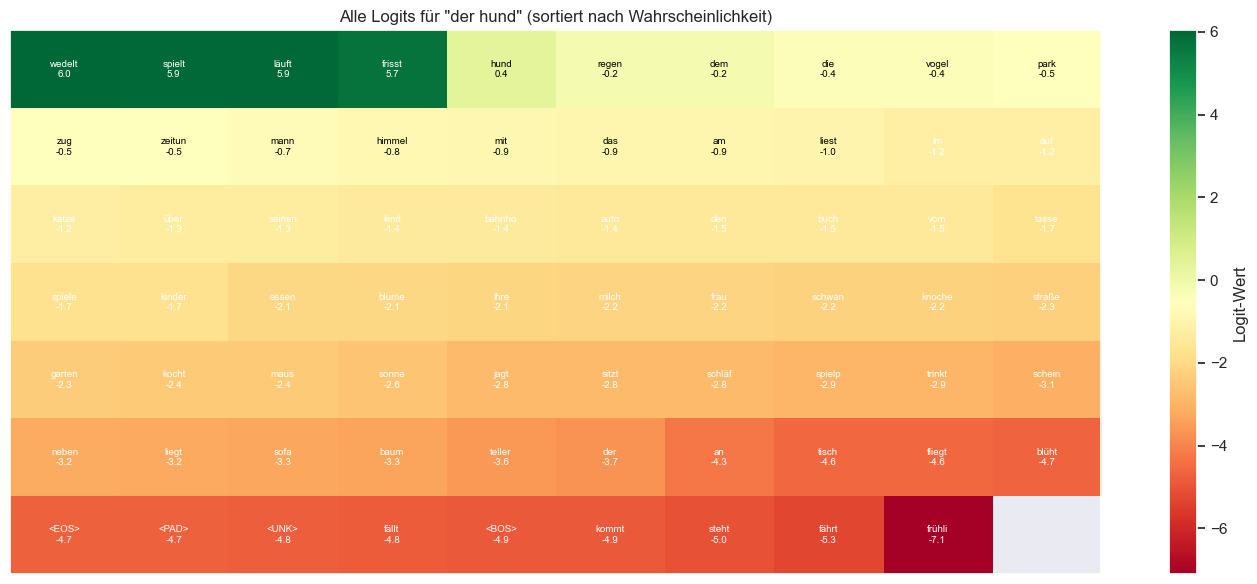

In [6]:
def plot_full_logits_heatmap(model, tokenizer, text):
    """Zeigt alle Logits als Heatmap - ein Wert pro Wort im Vokabular."""
    logits, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Sortiere nach Wahrscheinlichkeit
    sorted_indices = np.argsort(probs)[::-1]
    sorted_logits = logits[sorted_indices]
    sorted_words = [tokenizer.idx_to_word.get(i, "?")[:10] for i in sorted_indices]
    
    # Heatmap (als 2D-Matrix reshaped)
    n_words = len(sorted_logits)
    cols = 10
    rows = (n_words + cols - 1) // cols
    
    # Padding falls nötig
    padded_logits = np.pad(sorted_logits, (0, rows * cols - n_words), constant_values=np.nan)
    matrix = padded_logits.reshape(rows, cols)
    
    fig, ax = plt.subplots(figsize=(14, max(6, rows * 0.5)))
    
    im = ax.imshow(matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, ax=ax, label='Logit-Wert')
    
    # Labels
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < n_words:
                word = sorted_words[idx][:6]
                val = sorted_logits[idx]
                color = 'white' if abs(val) > 1 else 'black'
                ax.text(j, i, f"{word}\n{val:.1f}", ha='center', va='center', 
                       fontsize=7, color=color)
    
    ax.set_title(f'Alle Logits für "{text}" (sortiert nach Wahrscheinlichkeit)')
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

plot_full_logits_heatmap(model, tokenizer, "der hund")

## 5. Generierungsprozess Schritt für Schritt

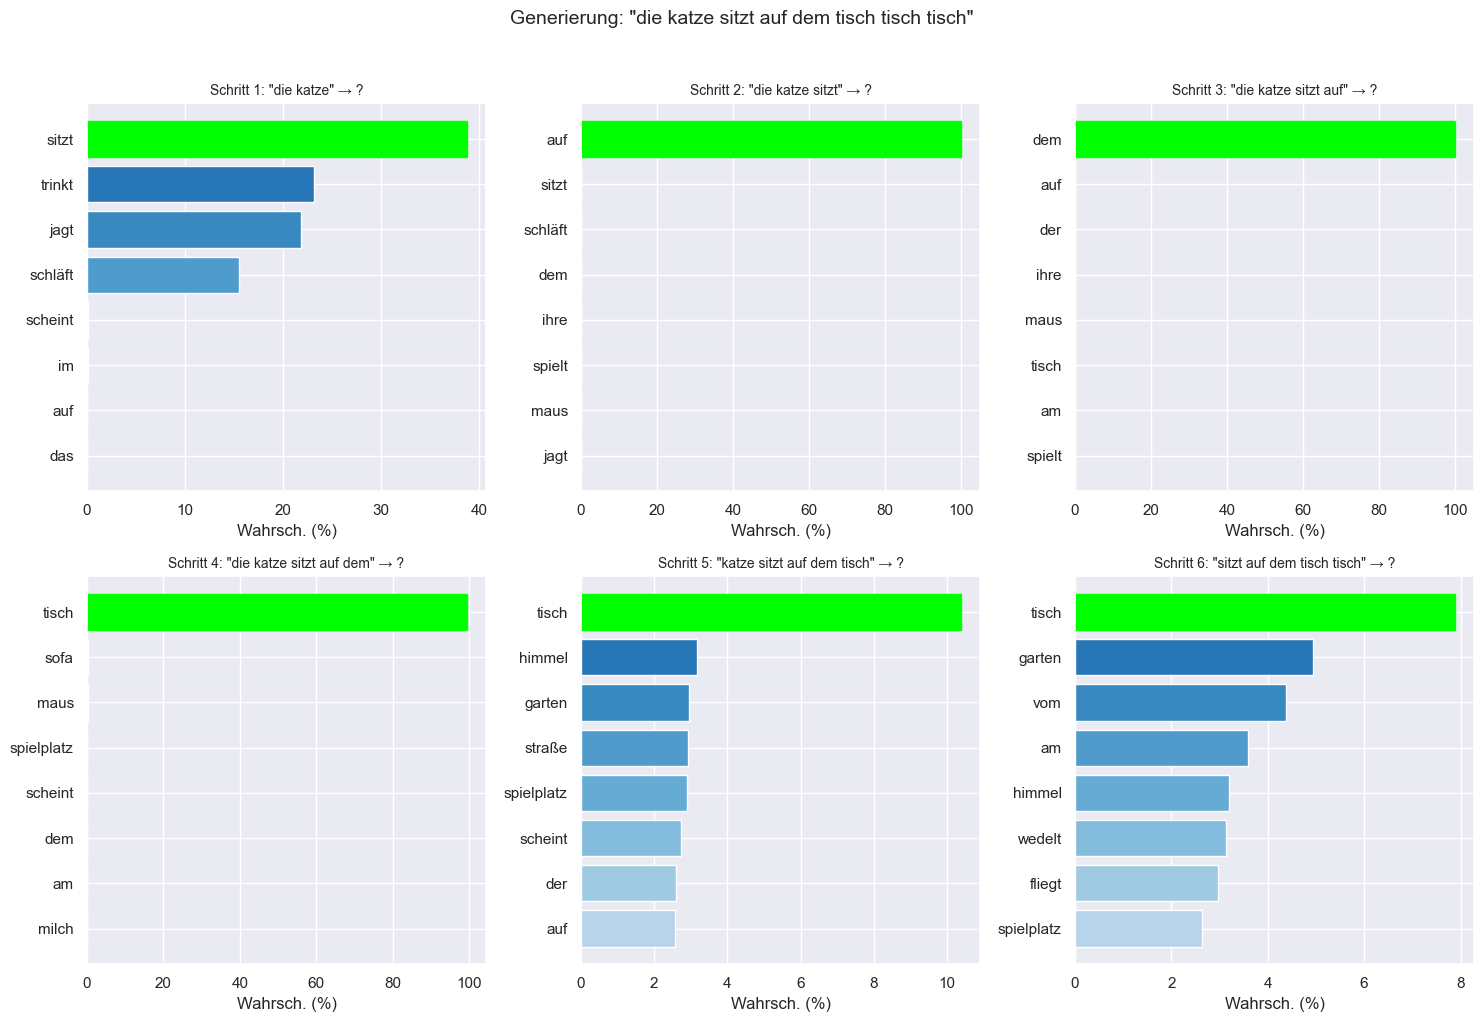

In [7]:
def visualize_generation_steps(model, tokenizer, start_text, max_steps=6, top_k=8):
    """Visualisiert jeden Schritt der Text-Generierung."""
    model.eval()
    
    tokens = tokenizer.encode(start_text)
    generated_words = start_text.split()
    
    # Sammle Daten für alle Schritte
    all_probs = []
    all_words = []
    chosen_words = []
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for step in range(min(max_steps, 6)):
        context = tokens[-5:] if len(tokens) > 5 else tokens
        
        with torch.no_grad():
            input_tensor = torch.tensor(context).unsqueeze(0)
            logits = model(input_tensor)
            last_logits = logits[0, -1, :]
            probs = F.softmax(last_logits, dim=-1).numpy()
        
        # Top-K
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_probs = probs[top_indices]
        top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
        
        # Wähle nächstes Wort (greedy für Visualisierung)
        next_token = top_indices[0]
        next_word = top_words[0]
        
        # Plot
        ax = axes[step]
        colors = plt.cm.Blues(np.linspace(0.8, 0.3, top_k))
        bars = ax.barh(range(top_k), top_probs * 100, color=colors)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Wahrsch. (%)')
        
        context_text = tokenizer.decode(context)
        ax.set_title(f'Schritt {step+1}: "{context_text}" → ?', fontsize=10)
        ax.invert_yaxis()
        
        # Markiere gewähltes Wort
        bars[0].set_color('lime')
        
        # EOS Check
        if next_token == tokenizer.word_to_idx.get(tokenizer.eos_token):
            ax.annotate('EOS!', xy=(0.5, 0.5), xycoords='axes fraction',
                       fontsize=20, color='red', ha='center')
            break
        
        tokens.append(next_token)
        generated_words.append(next_word)
    
    # Verstecke ungenutzte Subplots
    for i in range(step + 1, 6):
        axes[i].axis('off')
    
    plt.suptitle(f'Generierung: "{" ".join(generated_words)}"', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return " ".join(generated_words)

# Visualisieren
result = visualize_generation_steps(model, tokenizer, "die katze", max_steps=6)

## 6. Vergleich mehrerer Eingaben

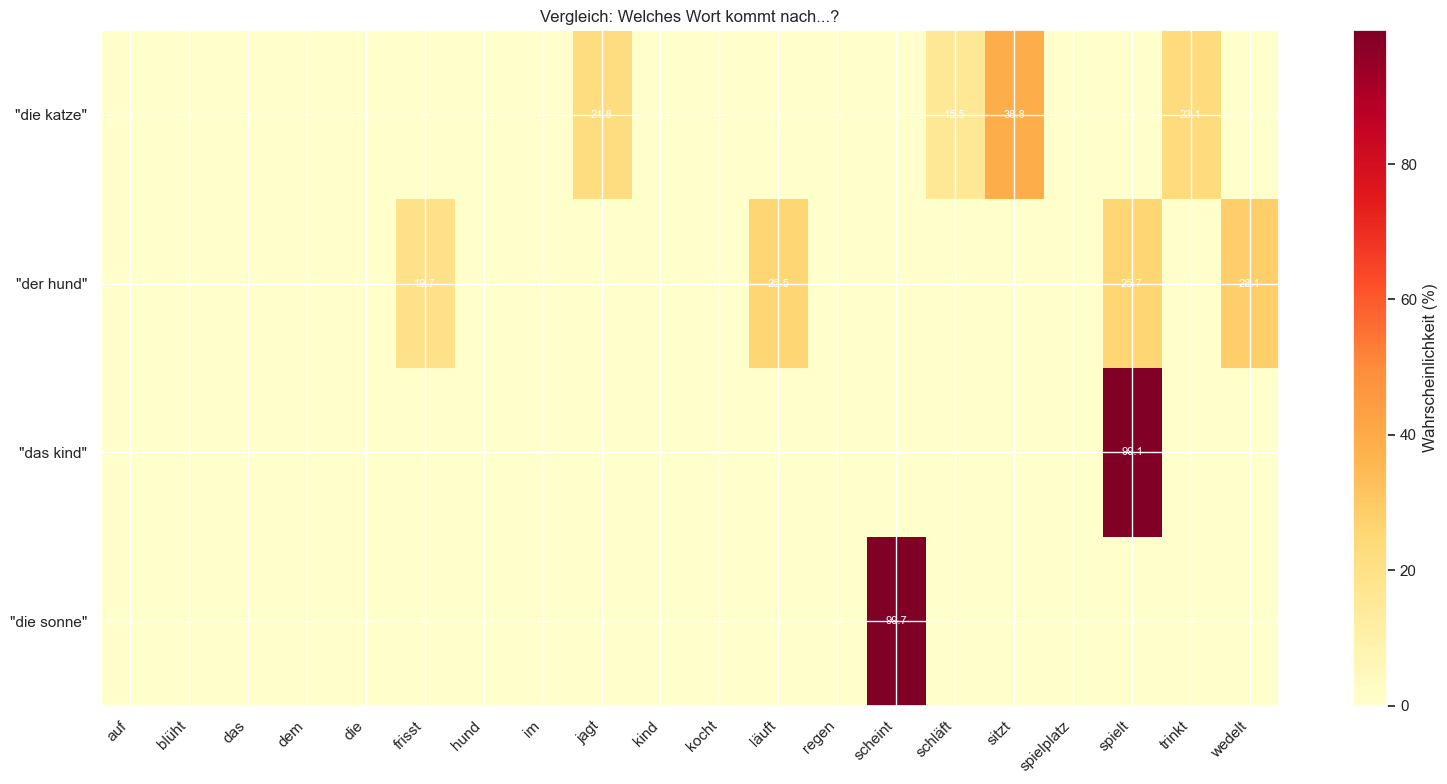

In [8]:
def compare_inputs_heatmap(model, tokenizer, texts, top_k=10):
    """Vergleicht die Top-K Vorhersagen für mehrere Eingaben als Heatmap."""
    
    # Sammle alle Top-Wörter
    all_top_words = set()
    text_probs = {}
    
    for text in texts:
        _, probs, _ = get_logits_and_probs(model, tokenizer, text)
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
        all_top_words.update(top_words)
        text_probs[text] = {tokenizer.idx_to_word.get(i, "?"): probs[i] for i in top_indices}
    
    # Sortiere Wörter
    all_top_words = sorted(all_top_words)
    
    # Erstelle Matrix
    matrix = np.zeros((len(texts), len(all_top_words)))
    for i, text in enumerate(texts):
        for j, word in enumerate(all_top_words):
            matrix[i, j] = text_probs[text].get(word, 0) * 100
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(12, len(all_top_words) * 0.8), len(texts) * 1.5 + 2))
    
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im, ax=ax, label='Wahrscheinlichkeit (%)')
    
    ax.set_xticks(range(len(all_top_words)))
    ax.set_xticklabels(all_top_words, rotation=45, ha='right')
    ax.set_yticks(range(len(texts)))
    ax.set_yticklabels([f'"{t}"' for t in texts])
    
    # Werte in Zellen
    for i in range(len(texts)):
        for j in range(len(all_top_words)):
            val = matrix[i, j]
            if val > 0.5:
                color = 'white' if val > 5 else 'black'
                ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=8, color=color)
    
    ax.set_title('Vergleich: Welches Wort kommt nach...?')
    plt.tight_layout()
    plt.show()

# Vergleiche
compare_inputs_heatmap(model, tokenizer, [
    "die katze",
    "der hund",
    "das kind",
    "die sonne"
], top_k=8)

## 7. Wahrscheinlichkeitsverteilung (Pie Chart)

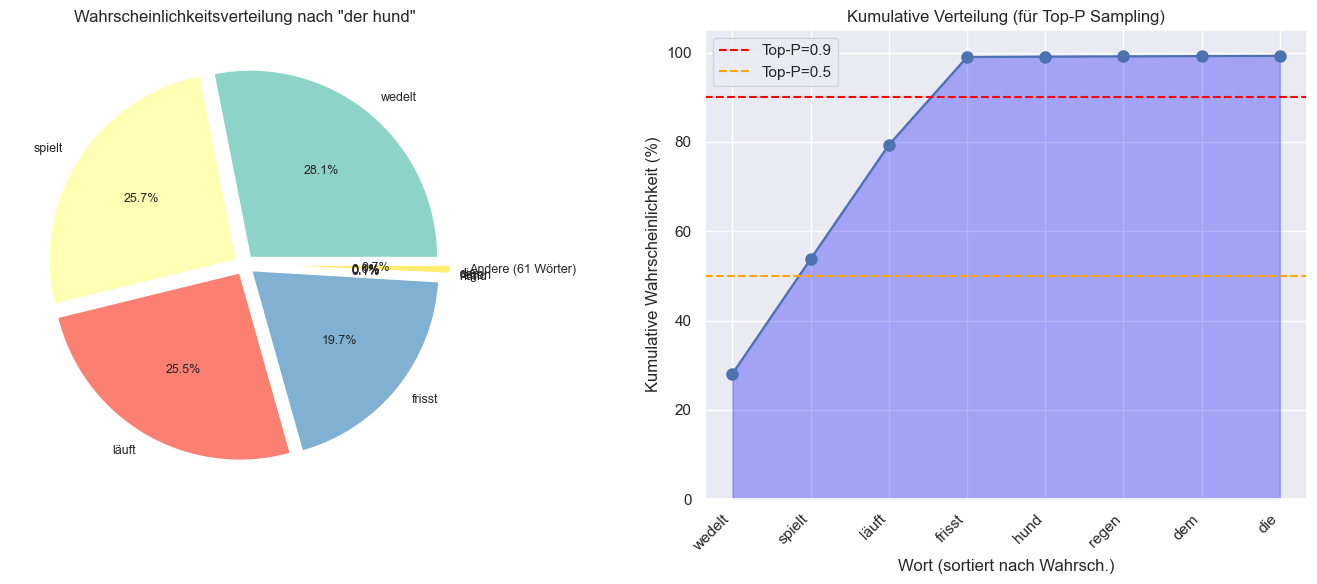

In [9]:
def plot_probability_pie(model, tokenizer, text, top_k=8):
    """Zeigt die Wahrscheinlichkeitsverteilung als Kreisdiagramm."""
    _, probs, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K + Rest
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_words = [tokenizer.idx_to_word.get(i, "?") for i in top_indices]
    
    rest_prob = 1.0 - sum(top_probs)
    
    labels = top_words + [f'Andere ({tokenizer.vocab_size - top_k} Wörter)']
    sizes = list(top_probs) + [rest_prob]
    
    # Farben
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie Chart
    explode = [0.05] * top_k + [0.1]
    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                                        explode=explode, colors=colors, 
                                        textprops={'fontsize': 9})
    ax1.set_title(f'Wahrscheinlichkeitsverteilung nach "{text}"')
    
    # Kumulative Verteilung
    cumsum = np.cumsum(top_probs)
    ax2.fill_between(range(top_k), cumsum * 100, alpha=0.3, color='blue')
    ax2.plot(range(top_k), cumsum * 100, 'bo-', markersize=8)
    ax2.set_xticks(range(top_k))
    ax2.set_xticklabels(top_words, rotation=45, ha='right')
    ax2.set_ylabel('Kumulative Wahrscheinlichkeit (%)')
    ax2.set_xlabel('Wort (sortiert nach Wahrsch.)')
    ax2.set_title('Kumulative Verteilung (für Top-P Sampling)')
    ax2.axhline(y=90, color='red', linestyle='--', label='Top-P=0.9')
    ax2.axhline(y=50, color='orange', linestyle='--', label='Top-P=0.5')
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()

plot_probability_pie(model, tokenizer, "der hund", top_k=8)

## 8. Interaktive Eingabe

In [ ]:
# Eigenen Text eingeben und analysieren
eingabe = "die katze sitzt"  # <-- Hier eigenen Text eingeben!

print(f"Analyse für: '{eingabe}'\n")
print("=" * 50)

# Alle Visualisierungen
plot_top_k_bar(model, tokenizer, eingabe, top_k=10)
plot_probability_pie(model, tokenizer, eingabe, top_k=8)

## 9. Temperatur-Vergleich

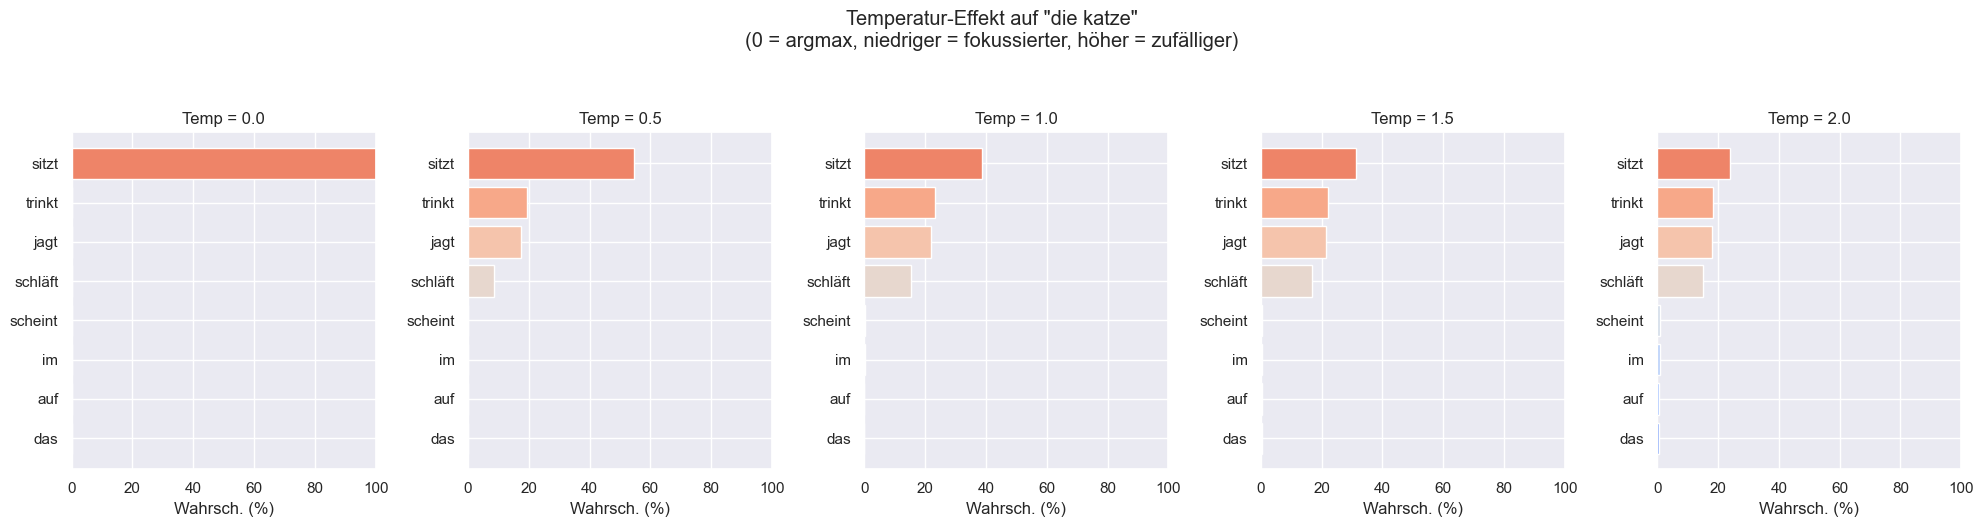

In [15]:
def compare_temperatures(model, tokenizer, text, temperatures=[0.0, 0.5, 1.0, 1.5, 2.0], top_k=8):
    """Zeigt wie Temperature die Wahrscheinlichkeitsverteilung beeinflusst.
    
    Temperature = 0: Argmax (deterministisch, Top-Wort bekommt 100%)
    Temperature = 1: Standard Softmax
    Temperature > 1: Flachere Verteilung (mehr Zufall)
    Temperature < 1: Schärfere Verteilung (weniger Zufall)
    """
    logits, _, _ = get_logits_and_probs(model, tokenizer, text)
    
    # Top-K basierend auf originalen Logits (gleich für alle Temperaturen!)
    top_indices = np.argsort(logits)[-top_k:][::-1]
    top_words = [tokenizer.idx_to_word.get(i, "?")[:8] for i in top_indices]
    
    fig, axes = plt.subplots(1, len(temperatures), figsize=(4*len(temperatures), 5))
    
    for ax, temp in zip(axes, temperatures):
        if temp == 0:
            # Temperatur 0 = Argmax: Top-Wort bekommt 100%, Rest 0%
            probs = np.zeros_like(logits)
            probs[np.argmax(logits)] = 1.0
        else:
            # Logits mit Temperature skalieren
            scaled_logits = logits / temp
            probs = F.softmax(torch.tensor(scaled_logits), dim=-1).numpy()
        
        # Wahrscheinlichkeiten für die (gleichen) Top-K Wörter
        top_probs = probs[top_indices]
        
        # Plot
        colors = plt.cm.coolwarm(np.linspace(0.8, 0.2, top_k))
        ax.barh(range(top_k), top_probs * 100, color=colors)
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Wahrsch. (%)')
        ax.set_title(f'Temp = {temp}')
        ax.invert_yaxis()
        ax.set_xlim(0, 100)
    
    plt.suptitle(f'Temperatur-Effekt auf "{text}"\n(0 = argmax, niedriger = fokussierter, höher = zufälliger)', y=1.05)
    plt.tight_layout()
    plt.show()

compare_temperatures(model, tokenizer, "die katze")

## 10. Logits über Sequenz (alle Positionen)

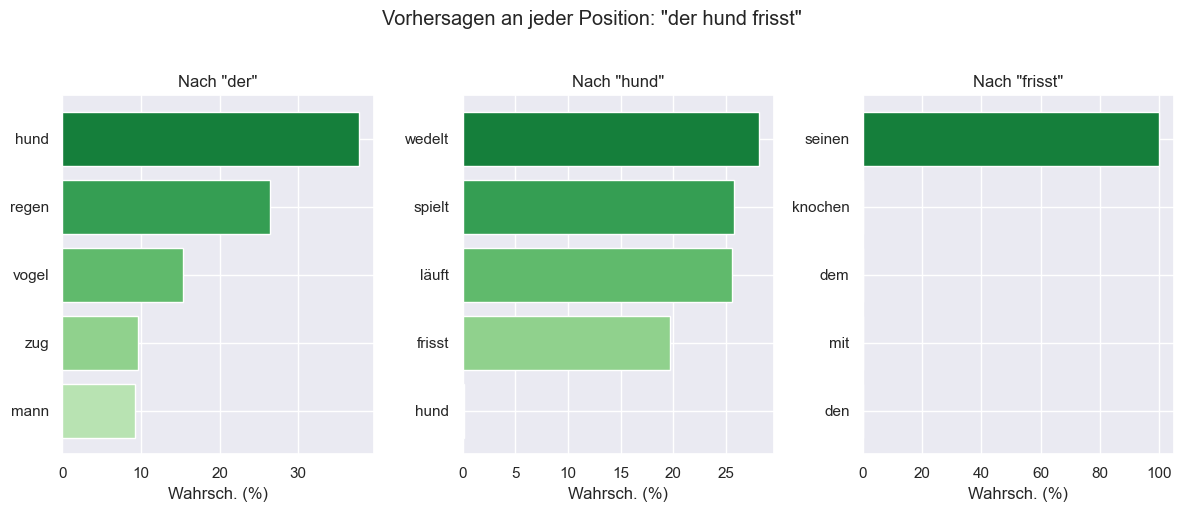

In [16]:
def plot_sequence_logits(model, tokenizer, text, top_k=5):
    """Zeigt die Logits für jede Position in der Sequenz."""
    model.eval()
    tokens = tokenizer.encode(text)
    words = text.lower().split()
    
    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        all_logits = model(input_tensor)[0]  # [seq_len, vocab_size]
    
    fig, axes = plt.subplots(1, len(words), figsize=(4*len(words), 5))
    if len(words) == 1:
        axes = [axes]
    
    for pos, (ax, word) in enumerate(zip(axes, words)):
        logits = all_logits[pos].numpy()
        probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
        
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_probs = probs[top_indices]
        top_words = [tokenizer.idx_to_word.get(i, "?")[:8] for i in top_indices]
        
        ax.barh(range(top_k), top_probs * 100, color=plt.cm.Greens(np.linspace(0.8, 0.3, top_k)))
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Wahrsch. (%)')
        ax.set_title(f'Nach "{word}"')
        ax.invert_yaxis()
    
    plt.suptitle(f'Vorhersagen an jeder Position: "{text}"', y=1.02)
    plt.tight_layout()
    plt.show()

plot_sequence_logits(model, tokenizer, "der hund frisst")